In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

In [2]:
current_dir = Path(os.getcwd())
project_dir = current_dir.parent.parent.absolute()

## 1. construct toy invariant-mass spectrum
--------------------------------------------
The purpose of this notebook to recover the energy spectrum of a nuclear decay generated from Breit-Wigner distribution.
$$
    f(E) = \dfrac{1}{2}\sum_i \dfrac{A_i \Gamma_i}{(E - E_i)^2 + \Gamma_i^2}
$$


In [3]:
def Breit_Wigner(x, centers, amplitudes, widths):
    assert len(centers) == len(amplitudes) == len(widths)
    return 0.5 * np.sum([
        amplitudes[i] * widths[i] / ((x - centers[i]) ** 2 + widths[i] ** 2) for i in range(len(centers))
    ], axis=0)


In [4]:
# centers, amplitudes, widths
params = [
    [1, 2, 4], 
    np.array([150, 90, 100]) / 3, 
    [0.5, 0.2, 3]
]

x = np.linspace(0, 10, 50)
model = Breit_Wigner(x, *params)

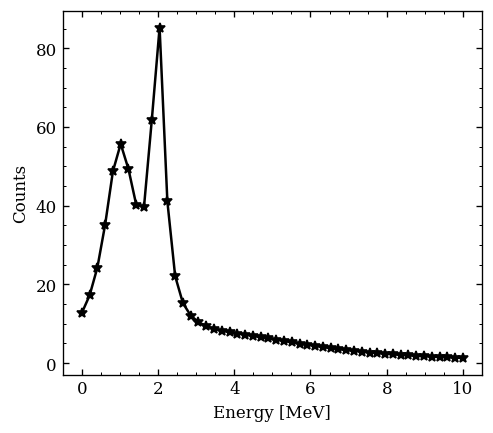

In [9]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(x, model, label='Breit-Wigner', color='black', marker='*', ls='-')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Counts')
plt.show()


## 2. construct a made-up blur kernel
--------------------------------------
To apply RL algorithm, we need to create simulated data. In this case the data is generated by blurring the smooth distribution.

In [6]:
def convolution_kernel(x):
    gaus = lambda x, mu, sigma: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    psf = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            d = abs(j-i)
            if d == 0:
                psf[i,j] = 0.5
            elif d <= 10:
                psf[i,j] = 0.5 / 6

            psf[i,j] += gaus(d, 0, 4)
    return psf
                

In [7]:
K = convolution_kernel(x)
K = K / np.sum(K, axis=0)

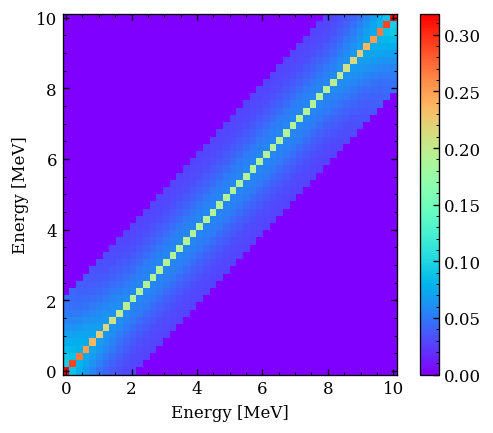

In [8]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
h = ax.pcolormesh(x, x, K, cmap='rainbow')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Energy [MeV]')
fig.colorbar(h, ax=ax)
plt.show()

In [9]:
def richardson_lucy_std(niter, X, y, psf, return_all=False):
    y_norm = np.sum(y)
    psf_norm = np.sum(psf, axis=0)

    psf_ = psf / psf_norm
    img = y / y_norm
    deconv = X / np.sum(X)
    conv = np.dot(psf_, deconv) + 1e-12


    X_preds = []
    y_preds = []

    for _ in range(niter):
        deconv = deconv * np.einsum('i,ij', img / conv, psf_)
        conv = np.dot(psf_, deconv) + 1e-12

        X_preds.append(deconv * y_norm / psf_norm)
        y_preds.append(conv * y_norm)
        
    if return_all:
        return X_preds, y_preds
    
    return X_preds[-1], y_preds[-1]

In [10]:
restored, predicted = richardson_lucy_std(
    niter = 1000,
    X = np.ones_like(model),
    y = np.dot(K, model),
    psf = K,
    return_all=True
)

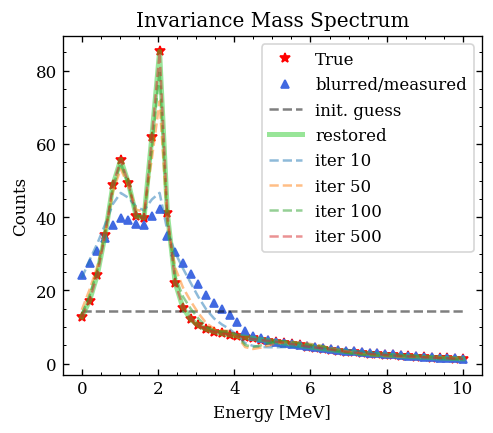

In [11]:
fig, ax = plt.subplots(1,1, constrained_layout=True)
ax.plot(x, model, label='True', color='red', marker='*', ls='none')
ax.plot(x, np.dot(K, model), label='blurred/measured', marker='^', color='royalblue', ls='none', ms=5)
ax.plot(x, np.ones_like(model) * np.mean(np.dot(K, model)), label='init. guess', color='black', ls='--', alpha=0.5)
ax.plot(x, restored[-1], label='restored', color='limegreen', ls='-', lw=3, alpha=0.5)

for i in [10,50,100,500]:
    ax.plot(x, restored[i], label=f'iter {i}', alpha=0.5, ls='--')

ax.legend()
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Counts')
ax.set_title('Invariance Mass Spectrum')

plt.show()